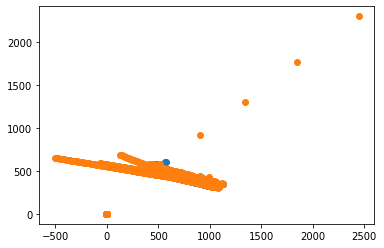

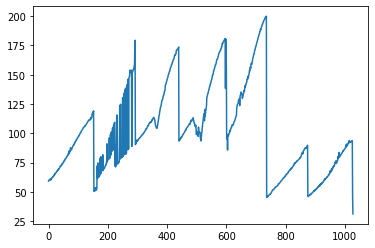

In [1]:
import cv2
import numpy as np
import glob

            
def update(x, P, Z, H, R):
    y = Z -np.dot(H, x)
    S = np.dot(np.dot(H, P), np.transpose(H)) + R
    K = np.dot(np.dot(P, np.transpose(H)), np.linalg.pinv(S))
    return [x + np.dot(K, y), np.dot((np.eye(x.shape[0]) - np.dot(K, H)), P)]    
    
def predict(x, P, F, u):
    return [np.dot(F, x) + u, np.dot(np.dot(F, P), np.transpose(F))]

def initialize(x):  
    ### Initialize Kalman filter ###
    # The initial state (6x1).
    # The initial state. The robot starts in position 0 with the velocity 0.
    #x = np.array([[0], # Position along the x-axis
    #              [0], # Velocity along the x-axis
    #              [0], # Position along the y-axis   
    #              [0], # Velocity along the y-axis
    #              [0], # Position along the z-axis
    #              [0]])# Velocity along the z-axis

    # The initial uncertainty (6x6).
    P = np.array([[10, 0, 0, 0, 0, 0],
                  [0, 10, 0, 0, 0, 0],
                  [0, 0, 10, 0, 0, 0],
                  [0, 0, 0, 10, 0, 0],
                  [0, 0, 0, 0, 10, 0],
                  [0, 0, 0, 0, 0, 10]])

    # The external motion (6x1).
    u = np.array([[0],
                  [0],
                  [0],
                  [0],
                  [0],
                  [0]])

    # The transition matrix (6x6). 
    F = np.array([[1, 1, 0.5, 0, 0, 0],
                  [0, 1, 1,   0, 0, 0], 
                  [0, 0, 1,   0, 0, 0],
                  [0, 0, 0,   1, 1, 0.5],
                  [0, 0, 0,   0, 1, 1],
                  [0, 0, 0,   0, 0, 1]])
    """
    F = np.array([[1, 1, 0, 0, 0, 0],
                  [0, 1, 0, 0, 0, 0], 
                  [0, 0, 1, 1, 0, 0],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 1],
                  [0, 0, 0, 0, 0, 1]])
    """
    # The observation matrix (2x6).
    H = np.array([[1, 0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0, 0]])

    #H = np.array([[1, 0, 0, 0, 0, 0],
    #              [0, 0, 1, 0, 0, 0],
    #              [0, 0, 0, 0, 1, 0]])

    # The measurement uncertainty.
    R = 10
    
    return x, u, F, P, R, H

def beltmask(img):
    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return cv2.bitwise_not(cv2.inRange(hsv, np.array([100,50,50]), np.array([115,255,255])))

def objectmask(frame, bgs):
    fgMask = bgs.apply(frame)

    kernel = np.ones((5,5), np.uint8) 

    fgMask = cv2.dilate(fgMask, kernel, iterations=1) 

    contours, _ = cv2.findContours(fgMask,2,1)            
    contours = sorted(contours, key=cv2.contourArea)            
    out_mask = np.zeros_like(fgMask)
    cv2.drawContours(out_mask, [contours[-1]], -1, 255, cv2.FILLED, 1)  
    return out_mask

def findobjectbounds(mask):
    contours, _ = cv2.findContours(mask,2,1) 
    if contours:
        c = max(contours, key=cv2.contourArea)
        ((center_x, center_y), radius) = cv2.minEnclosingCircle(c)
        return center_x, center_y, radius
    else:
        return 0, 0, 0

leftImages = glob.glob('./Stereo_conveyor_without_occlusions/left/*.png')
frame = cv2.imread(leftImages[0])

backSub = cv2.createBackgroundSubtractorMOG2(30, 16, False)
_ = backSub.apply(frame)

prev_center_x, prev_center_y = 0, 0
measure_history = []
prediction_history = []
radius_history = []
center_on_belt = False
prev_center_on_belt = False
for i, img in enumerate(leftImages[1:]):
    frame = cv2.imread(img)
    
    center_x, center_y = 0, 0
    
    object_mask = objectmask(frame, backSub)
    belt_mask = beltmask(frame)

    result = cv2.bitwise_and(object_mask, object_mask, mask=belt_mask)
    
    center_x, center_y, radius = findobjectbounds(result)
    
    
    pts = np.array([[390, 470],[1050,290],[1160,360],[440,670]], np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(frame,[pts],True,(255,0,255))
    if cv2.pointPolygonTest(pts, (center_x, center_y), False) < 0:
        center_x, center_y = 0, 0
        center_on_belt = False
    else:
        center_on_belt = True
        
    prev_center_x, prev_center_y = center_x, center_y
    if cv2.norm(np.array([[center_x, center_y]]), np.array([[prev_center_x, prev_center_y]])) > 20:
        center_x, center_y = 0, 0
        
    if radius < 30 or radius > 200:
        center_x, center_y = 0, 0
        
    for c_x, c_y in measure_history: #draws previous centers
        cv2.circle(frame, (int(c_x), int(c_y)), 1, (0, 255, 255), -1) #center
        
    if center_on_belt and not prev_center_on_belt:
        x, u, F, P, R, H = initialize(np.array([[center_x], [-0.15], [0], [center_y], [0.04], [0]]))
        
    
    if center_x != 0 and center_y != 0:
        radius_history.append(radius)
        measure_history.append((center_x, center_y))
        frame = cv2.addWeighted(frame, 1, cv2.bitwise_and(frame,frame,mask = result), 1, 0)
        cv2.circle(frame, (int(center_x), int(center_y)), int(radius), (0, 0, 255), 2) #cirle
        cv2.circle(frame, (int(center_x), int(center_y)), 5, (0, 0, 255), -1) #center
    
        z = np.array([[center_x],
                      [center_y]])
        #print(z)
        [x, P] = update(x, P, z, H, R) 
    else:
        pass
        #print("not detected")
        
    ### Predict the next state
    [x, P] = predict(x, P, F, u)
    #print(x)
    
    ### Draw the current tracked state and the predicted state on the image frame ###
    x_pred, y_pred = np.matmul(H, x).ravel()
    prediction_history.append((x_pred, y_pred))
    cv2.circle(frame,(int(x_pred), int(y_pred)), 5, (255,0,0),-1)
    
    prev_center_on_belt = center_on_belt
    
    # Show the frame
    cv2.imshow('Frame', frame)
    cv2.waitKey(50)

cv2.destroyAllWindows()


import matplotlib.pyplot as plt
x_meas = [i[0] for i in measure_history]
y_meas = [i[1] for i in measure_history]
x_pred = [i[0] for i in prediction_history]
y_pred = [i[1] for i in prediction_history]
plt.scatter(x_meas, y_meas)
plt.scatter(x_pred, y_pred)
plt.figure()
plt.plot(radius_history)
plt.show()